In [1]:
import spotipy
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy import stats
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.model_selection import train_test_split
import spotify
%load_ext autoreload
%autoreload 2

from config import (
    api_key_lastfm,
    client_secret_lastfm,
    client_id,
    client_secret,
    redirect_uri
)

In [3]:
### LastFM API in order to get more details about tracks and artists

api_key_lastfm = '573c8f11cf55d884195e59ce46660f38'
client_secret_lastfm = 'c153fb332aee6734dcfa8d8b97f912d6'

In [ ]:
#### list of different methods used in this API

##### By artist
###### artist.getTopTracks → Liste les morceaux les plus populaires d’un artiste
###### artist.getTopAlbums → Donne les albums les plus populaires d’un artiste
###### artist.getSimilar → Trouve des artistes similaires
###### artist.getTags → Affiche les tags (genres musicaux) associés à un artiste
###### artist.search → Recherche un artiste par nom

##### By album
###### album.getInfo → Récupère des informations sur un album (date de sortie, tracklist...).
###### album.getTopTags → Affiche les genres associés à un album.
###### album.search → Recherche un album par nom.

##### By track
###### track.getInfo → Donne les détails d’un morceau (durée, album, artistes, écouteurs récents...)
###### track.getSimilar → Propose des morceaux similaires
###### track.getTopTags → Donne les genres/tags associés à un morceau
###### track.search → Recherche un morceau par nom

##### By trend
###### chart.getTopArtists → Liste les artistes les plus populaires du moment.
###### chart.getTopTracks → Liste les morceaux les plus écoutés.
###### chart.getTopTags → Affiche les genres musicaux populaires.

##### By tag
###### tag.getInfo → Récupère des infos sur un genre musical.
###### tag.getTopArtists → Affiche les artistes les plus populaires dans un genre donné.
###### tag.getTopAlbums → Affiche les albums les plus populaires dans un genre.
###### tag.getTopTracks → Affiche les morceaux les plus populaires dans un genre.

In [266]:
def get_artist_details(artist, api_key, method):
    url = 'http://ws.audioscrobbler.com/2.0/?'

    endpoint = f'method={method}&artist={artist}&api_key={api_key}&format=json'

    response = requests.get(url+endpoint)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print('error :', response.status_code, response.text)

In [344]:
get_artist_details('Jul', api_key_lastfm, 'artist.getInfo')['artist']['tags']['tag']

[{'name': 'rap', 'url': 'https://www.last.fm/tag/rap'},
 {'name': 'Hip-Hop', 'url': 'https://www.last.fm/tag/Hip-Hop'},
 {'name': 'french', 'url': 'https://www.last.fm/tag/french'},
 {'name': 'fragile', 'url': 'https://www.last.fm/tag/fragile'},
 {'name': 'Marseille', 'url': 'https://www.last.fm/tag/Marseille'}]

In [22]:
def get_track_details(track, artist, api_key, method):
    url = 'http://ws.audioscrobbler.com/2.0/?'

    endpoint = f'method={method}&api_key={api_key}&artist={artist}&track={track}&format=json'

    response = requests.get(url+endpoint)

    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print('error :', response.status_code, response.text)

In [35]:
get_track_details('Astroboy', 'Zola', api_key_lastfm, 'track.getSimilar')

{'similartracks': {'track': [{'name': 'Fuckboi',
    'playcount': 103259,
    'match': 1.0,
    'url': 'https://www.last.fm/music/Zola/_/Fuckboi',
    'streamable': {'#text': '0', 'fulltrack': '0'},
    'artist': {'name': 'Zola',
     'mbid': 'bf7127d0-85b4-418c-89f1-316cdff30918',
     'url': 'https://www.last.fm/music/Zola'},
    'image': [{'#text': 'https://lastfm.freetls.fastly.net/i/u/34s/2a96cbd8b46e442fc41c2b86b821562f.png',
      'size': 'small'},
     {'#text': 'https://lastfm.freetls.fastly.net/i/u/64s/2a96cbd8b46e442fc41c2b86b821562f.png',
      'size': 'medium'},
     {'#text': 'https://lastfm.freetls.fastly.net/i/u/174s/2a96cbd8b46e442fc41c2b86b821562f.png',
      'size': 'large'},
     {'#text': 'https://lastfm.freetls.fastly.net/i/u/300x300/2a96cbd8b46e442fc41c2b86b821562f.png',
      'size': 'extralarge'},
     {'#text': 'https://lastfm.freetls.fastly.net/i/u/300x300/2a96cbd8b46e442fc41c2b86b821562f.png',
      'size': 'mega'},
     {'#text': 'https://lastfm.freetls.fas

In [15]:
### Spotify
client_id = '110a5d0ef38a41248a97fe6f996115ba'
client_secret = '144cf322d18a4a088340dcd4fb0f7148'
redirect_uri = "http://localhost:8080"

In [126]:
### Get the access token
url = "https://accounts.spotify.com/api/token"

data = {
    "grant_type": "client_credentials",
    "client_id": client_id,
    "client_secret": client_secret
}

headers = {
    "Content-Type": "application/x-www-form-urlencoded"
}

response = requests.post(url, data=data, headers=headers)

if response.status_code == 200:
    access_token = response.json()['access_token']
    print("Access Token:", access_token)
else:
    print("Erreur lors de l'obtention du token:", response.status_code, response.text)

Access Token: BQCN6ngBSojyjpyUWy32dvvwng2LEd3OWJGHHBV3GLUD4w-gyO1fNMstGITc89WnBkevlcqR264gb_HR4bpKIKJ64Pngnl9eL1Uth-5xt1x0TPRDXkj7bMVBGQVub9iVnK9lPVKHr78


In [16]:
### Use directly spotify API 
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id = client_id,
    client_secret = client_secret,
    redirect_uri = redirect_uri,
    scope = "user-top-read user-read-private user-library-read playlist-read-private user-read-playback-state user-read-recently-played"
))

In [128]:
sp.current_user()

{'country': 'FR',
 'display_name': 'killianbchr',
 'explicit_content': {'filter_enabled': False, 'filter_locked': False},
 'external_urls': {'spotify': 'https://open.spotify.com/user/killianbchr'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/users/killianbchr',
 'id': 'killianbchr',
 'images': [],
 'product': 'premium',
 'type': 'user',
 'uri': 'spotify:user:killianbchr'}

In [19]:
sp.current_user_top_artists()['items']

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3vUMXQ9kPnZAQkMkZZ7Hfh'},
  'followers': {'href': None, 'total': 2715238},
  'genres': ['pop urbaine'],
  'href': 'https://api.spotify.com/v1/artists/3vUMXQ9kPnZAQkMkZZ7Hfh',
  'id': '3vUMXQ9kPnZAQkMkZZ7Hfh',
  'images': [{'height': 640,
    'url': 'https://i.scdn.co/image/ab6761610000e5eb4d4f46d8b3b786409a8c3219',
    'width': 640},
   {'height': 320,
    'url': 'https://i.scdn.co/image/ab676161000051744d4f46d8b3b786409a8c3219',
    'width': 320},
   {'height': 160,
    'url': 'https://i.scdn.co/image/ab6761610000f1784d4f46d8b3b786409a8c3219',
    'width': 160}],
  'name': 'Tiakola',
  'popularity': 73,
  'type': 'artist',
  'uri': 'spotify:artist:3vUMXQ9kPnZAQkMkZZ7Hfh'},
 {'external_urls': {'spotify': 'https://open.spotify.com/artist/3IW7ScrzXmPvZhB27hmfgy'},
  'followers': {'href': None, 'total': 10984603},
  'genres': ['pop urbaine', 'chicha'],
  'href': 'https://api.spotify.com/v1/artists/3IW7ScrzXmPvZhB27hmfgy',
  '

In [20]:
sp.current_user_playlists()

{'href': 'https://api.spotify.com/v1/users/killianbchr/playlists?offset=0&limit=50',
 'limit': 50,
 'next': None,
 'offset': 0,
 'previous': None,
 'total': 11,
 'items': [{'collaborative': False,
   'description': '',
   'external_urls': {'spotify': 'https://open.spotify.com/playlist/2n00gwlwkWkneHJj1HzZjM'},
   'href': 'https://api.spotify.com/v1/playlists/2n00gwlwkWkneHJj1HzZjM',
   'id': '2n00gwlwkWkneHJj1HzZjM',
   'images': [{'height': 640,
     'url': 'https://mosaic.scdn.co/640/ab67616d00001e02075ecd9bfd91eed22378226cab67616d00001e024121faee8df82c526cbab2beab67616d00001e0267dc806f8fe3044fd9fd186dab67616d00001e02a496dc8c33ca6d10668b3157',
     'width': 640},
    {'height': 300,
     'url': 'https://mosaic.scdn.co/300/ab67616d00001e02075ecd9bfd91eed22378226cab67616d00001e024121faee8df82c526cbab2beab67616d00001e0267dc806f8fe3044fd9fd186dab67616d00001e02a496dc8c33ca6d10668b3157',
     'width': 300},
    {'height': 60,
     'url': 'https://mosaic.scdn.co/60/ab67616d00001e02075ecd9bf

In [21]:
playlist_id = '2n00gwlwkWkneHJj1HzZjM'
sp.playlist_tracks(playlist_id)

{'href': 'https://api.spotify.com/v1/playlists/2n00gwlwkWkneHJj1HzZjM/tracks?offset=0&limit=100&additional_types=track',
 'items': [{'added_at': '2022-12-21T10:53:25Z',
   'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/killianbchr'},
    'href': 'https://api.spotify.com/v1/users/killianbchr',
    'id': 'killianbchr',
    'type': 'user',
    'uri': 'spotify:user:killianbchr'},
   'is_local': False,
   'primary_color': None,
   'track': {'preview_url': None,
    'available_markets': ['AR',
     'AU',
     'AT',
     'BE',
     'BO',
     'BR',
     'BG',
     'CA',
     'CL',
     'CO',
     'CR',
     'CY',
     'CZ',
     'DK',
     'DO',
     'DE',
     'EC',
     'EE',
     'SV',
     'FI',
     'FR',
     'GR',
     'GT',
     'HN',
     'HK',
     'HU',
     'IS',
     'IE',
     'IT',
     'LV',
     'LT',
     'LU',
     'MY',
     'MT',
     'MX',
     'NL',
     'NZ',
     'NI',
     'NO',
     'PA',
     'PY',
     'PE',
     'PH',
     'PL',
     'PT

In [167]:
sp.current_user_recently_played(limit=1)['items'][0]

{'track': {'album': {'album_type': 'album',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0bLmm8afVAt8Vb5nhPsx1B'},
     'href': 'https://api.spotify.com/v1/artists/0bLmm8afVAt8Vb5nhPsx1B',
     'id': '0bLmm8afVAt8Vb5nhPsx1B',
     'name': 'XV',
     'type': 'artist',
     'uri': 'spotify:artist:0bLmm8afVAt8Vb5nhPsx1B'}],
   'available_markets': ['AR',
    'AU',
    'AT',
    'BE',
    'BO',
    'BR',
    'BG',
    'CA',
    'CL',
    'CO',
    'CR',
    'CY',
    'CZ',
    'DK',
    'DO',
    'DE',
    'EC',
    'EE',
    'SV',
    'FI',
    'FR',
    'GR',
    'GT',
    'HN',
    'HK',
    'HU',
    'IS',
    'IE',
    'IT',
    'LV',
    'LT',
    'LU',
    'MY',
    'MT',
    'MX',
    'NL',
    'NZ',
    'NI',
    'NO',
    'PA',
    'PY',
    'PE',
    'PH',
    'PL',
    'PT',
    'SG',
    'SK',
    'ES',
    'SE',
    'CH',
    'TW',
    'TR',
    'UY',
    'US',
    'GB',
    'AD',
    'LI',
    'MC',
    'ID',
    'JP',
    'TH',
    'VN',
   

In [160]:
sp.current_user_recently_played(limit=1)['items'][0]['track']['artists']

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0bLmm8afVAt8Vb5nhPsx1B'},
  'href': 'https://api.spotify.com/v1/artists/0bLmm8afVAt8Vb5nhPsx1B',
  'id': '0bLmm8afVAt8Vb5nhPsx1B',
  'name': 'XV',
  'type': 'artist',
  'uri': 'spotify:artist:0bLmm8afVAt8Vb5nhPsx1B'}]

### Useful functions to get more informations about something

##### sp.artist(artist_id)
##### sp.album(album_id)
##### sp.track(track_id)
##### sp.audio_features(track_id)  -> track analysis
##### sp.artist_albums(artist_id)
##### sp.album_tracks(album_id)

In [362]:
def get_recent_tracks(numbers):
    all_tracks = []
    after = None

    while len(all_tracks) < numbers:
        limit = min(50, numbers - len(all_tracks))
        response = sp.current_user_recently_played(limit=limit, after=after)
        tracks = response.get('items', [])

        if not tracks:
            break

        all_tracks.extend(tracks)
        after = tracks[-1]['played_at']
        time.sleep(0.5)

    recent_tracks_df = pd.DataFrame()

    for track in all_tracks:
        album_track_df = pd.json_normalize(track['track']['album'])[['id', 'name', 'release_date', 'total_tracks']]
        album_track_df.rename(columns={'id':'album_id', 'name':'album_name'}, inplace=True)

        album_artist_str = ", ".join([artist['name'] for artist in track['track']['album']['artists']])
        album_artist_id_str = ", ".join([artist['id'] for artist in track['track']['album']['artists']])

        album_track_df['album_artists_id'] = album_artist_id_str
        album_track_df['album_artists_name'] = album_artist_str

        track_df = pd.json_normalize(track['track'])[['disc_number', 'duration_ms', 'id', 'name', 'popularity', 'track_number']]
        track_df['duration_ms'] = track_df['duration_ms']/1000
        track_df.rename(columns={'id':'track_id', 'name':'track_name', 'duration_ms':'duration'}, inplace=True)

        track_details = get_track_details(
            track=track['track']['name'], 
            artist=track['track']['artists'][0]['name'], 
            api_key=api_key_lastfm, 
            method='track.getInfo'
        )

        if "error" in track_details:
            track_details_df = pd.DataFrame(columns=['track_listeners', 'track_playcount'])
        else:
            track_details_df = pd.json_normalize(track_details.get('track', {})).get(['listeners', 'playcount'], pd.DataFrame())
            track_details_df.rename(columns={'listeners': 'track_listeners', 'playcount': 'track_playcount'}, inplace=True)

        track_artist_str = ", ".join([artist['name'] for artist in track['track']['artists']])
        track_artist_id_str = ", ".join([artist['id'] for artist in track['track']['artists']])

        track_df['track_artists_id'] = track_artist_id_str
        track_df['track_artists_name'] = track_artist_str

        ### Get similar artists and musical styles
        similar_artists_list = []
        track_tags_list = []
        for artist in track['track']['artists']:
            current_artist = artist['name']

            artist_details = get_artist_details(artist=current_artist, api_key=api_key_lastfm, method='artist.getInfo')

            if "error" in artist_details:
                similar_artists_list.append(None)
            else:
                similar_artists = artist_details.get('artist', {}).get('similar', {}).get('artist', [])
                similar_artists_list.extend([similar_artist['name'] for similar_artist in similar_artists])

            artist_details = get_artist_details(artist=current_artist, api_key=api_key_lastfm, method='artist.getInfo')

            if "error" in artist_details:
                track_tags_list.append(None)
            else:
                tags = artist_details.get('artist', {}).get('tags', {}).get('tag', [])
                track_tags_list.extend([tag['name'] for tag in tags])
            
        similar_artists_str = ", ".join([artist for artist in set(similar_artists_list) if artist is not None])     # Use of set in order to avoid duplicates
        track_tags_str = ", ".join([track for track in set(track_tags_list) if track is not None])      # Use of set in order to avoid duplicates

        track_df['similar_artists'] = similar_artists_str
        track_df['track_tags'] = track_tags_str

        played_at_df = pd.json_normalize(track)[['played_at']]

        context_df = pd.json_normalize(track['context'])[['type']]
        context_df.rename(columns={'type': 'context_type'}, inplace=True)

        album_track_df = pd.concat([album_track_df, track_df, track_details_df, played_at_df, context_df], axis=1)
        recent_tracks_df = pd.concat([recent_tracks_df, album_track_df], axis=0)
        time.sleep(0.5)

    recent_tracks_df.reset_index(inplace=True, drop=True)
    recent_tracks_df['release_date'] = pd.to_datetime(recent_tracks_df['release_date'])
    recent_tracks_df['played_at'] = pd.to_datetime(recent_tracks_df['played_at'])
    return recent_tracks_df

In [ ]:
### Paralléliser pour optimiser l'algo : 

        # Fonction pour récupérer les infos de chaque artiste en parallèle
        def fetch_artist_details(artist):
            current_artist = artist['name']
            artist_details = get_artist_details(artist=current_artist, api_key=api_key_lastfm, method='artist.getInfo')
            
            similar_artists = []
            tags = []

            if "error" not in artist_details:
                similar_artists = artist_details.get('artist', {}).get('similar', {}).get('artist', [])
                tags = artist_details.get('artist', {}).get('tags', {}).get('tag', [])

            return similar_artists, tags

        # Utilisation de ThreadPoolExecutor pour paralléliser les appels API
        with ThreadPoolExecutor() as executor:
            futures = {executor.submit(fetch_artist_details, artist): artist for artist in track['track']['artists']}
            for future in as_completed(futures):
                similar_artists, tags = future.result()

                if not similar_artists:
                    similar_artists_list.append(None)
                else:
                    similar_artists_list.extend([similar_artist['name'] for similar_artist in similar_artists])

                if not tags:
                    track_tags_list.append(None)
                else:
                    track_tags_list.extend([tag['name'] for tag in tags])

In [366]:
df = get_recent_tracks(1000)

In [367]:
df

,album_id,album_name,release_date,total_tracks,album_artists_id,album_artists_name,disc_number,duration,track_id,track_name,popularity,track_number,track_artists_id,track_artists_name,similar_artists,track_tags,track_listeners,track_playcount,played_at,context_type
0,6lR8cZ6omC8EJ0tzt7lNZh,LIFE,2025-01-31,15,6HCBnyTBSLdb3TFn2ayulY,Leto,1,128.437,74rjLS8piAqjqMzNOUA0Oz,SENTIMENTS BILLETS DE 100,0,14,6HCBnyTBSLdb3TFn2ayulY,Leto,"Mister V, Kerchak, Ikaz boi, Jok'Air, Gazo","french, rock, metal, electronic, frenchcore",2070,10553,2025-02-02 20:26:47.749000+00:00,album
1,6lR8cZ6omC8EJ0tzt7lNZh,LIFE,2025-01-31,15,6HCBnyTBSLdb3TFn2ayulY,Leto,1,129.000,1A4KZDNIdhelZdBE8RJHR2,SOUS LE SUN,0,13,6HCBnyTBSLdb3TFn2ayulY,Leto,"Mister V, Kerchak, Ikaz boi, Jok'Air, Gazo","french, rock, metal, electronic, frenchcore",391,811,2025-02-02 20:24:39.306000+00:00,album
2,6lR8cZ6omC8EJ0tzt7lNZh,LIFE,2025-01-31,15,6HCBnyTBSLdb3TFn2ayulY,Leto,1,136.875,6CirL8HwiWiVMyWaOTeNfl,TU RÉALISES,0,12,6HCBnyTBSLdb3TFn2ayulY,Leto,"Mister V, Kerchak, Ikaz boi, Jok'Air, Gazo","french, rock, metal, electronic, frenchcore",402,789,2025-02-02 20:22:30.299000+00:00,album
3,6lR8cZ6omC8EJ0tzt7lNZh,LIFE,2025-01-31,15,6HCBnyTBSLdb3TFn2ayulY,Leto,1,148.474,3REGYIB1hclkWybP7fkdvb,10 BOUTEILLES DE CHAMP,0,11,6HCBnyTBSLdb3TFn2ayulY,Leto,"Mister V, Kerchak, Ikaz boi, Jok'Air, Gazo","french, rock, metal, electronic, frenchcore",426,1002,2025-02-02 20:20:13.409000+00:00,album
4,3t1LD12LY64mEVWWKfbMeM,Movie,2024-10-23,1,4hYxvgmTzS29XAXlo5adgM,L2B,1,143.481,1k9oEJse03hhCI21JiOK4g,Movie,63,1,4hYxvgmTzS29XAXlo5adgM,L2B,"Tiakola, Genezio, Leto, RSKO, 4KEUS",,1424,11129,2025-02-02 20:17:44.567000+00:00,album
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2wPkvqKRnGNEMdiKUizinj,Demoniak,2016-05-20,15,34dSaKok3USBivMGTmIlXx,PSO THUG,1,261.725,50VyLr3bdBiwgb2cwDY96v,Plein les poches,35,8,"34dSaKok3USBivMGTmIlXx, 63MCBZRiUdnqRsAOJwijiB","PSO THUG, Sadek","Maes, LE MOTIF, Sazamyzy, Bené, Aladin 135, Ni...","french hip-hop, french rap, Des noirs cigarett...",2414,14830,2025-02-01 10:59:14.475000+00:00,playlist
996,3ZNdbFsn3KUTLtwEArMzLH,Mainmise,2019-07-05,16,0VF7XcB73fBSIfX9hOTVij,Dabs,1,209.065,2W1JSyFiR8V8cnObOsfzUi,Follow Back (feat. Aya Nakamura),43,9,"0VF7XcB73fBSIfX9hOTVij, 7IlRNXHjoOCgEAWN5qYksg","Dabs, Aya Nakamura","PLK, Enei, Shay, Tayc, Ulterior Motive, Wejden...","french, neurofunk, pop, Drum and bass, Drum n ...",2988,21113,2025-02-01 10:54:52.283000+00:00,playlist
997,7FTHvUVCnrtEvClzjYNvAD,11H (feat. Ninho),2022-03-10,1,"5eAv3bvAehIJEOMLtzAtaE, 6Te49r3A6f5BiIgBRxH7FH","Lamatrix, Ninho",1,180.053,2cs6Z8jGy5C0zP9kcEJi85,11H (feat. Ninho),37,1,"5eAv3bvAehIJEOMLtzAtaE, 6Te49r3A6f5BiIgBRxH7FH","Lamatrix, Ninho","Mougli, Alonzo, Booba, Graya, Gazo, Liim’s, Fr...","french, rap, trap, bolivia, Hip-Hop",2160,15315,2025-02-01 10:51:22.702000+00:00,playlist
998,5dgjmmhiSczIi2UsPmMNfy,Palavé (feat. Tiakola),2022-07-07,1,"3L774tiJRvPmAS90pOLB44, 3vUMXQ9kPnZAQkMkZZ7Hfh","Rsko, Tiakola",1,159.466,2zhF3nU2nZ67kCOkPOZLxy,Palavé (feat. Tiakola),40,1,"3L774tiJRvPmAS90pOLB44, 3vUMXQ9kPnZAQkMkZZ7Hfh","Rsko, Tiakola","Guy2Bezbar, Tiakola, RSKO, Gazo, WeRenoi, Ninh...","Franch rap, french, hip hop, rap",5077,52037,2025-02-01 10:48:22.194000+00:00,playlist


In [332]:
df.isnull().sum()

album_id              0
album_name            0
release_date          0
total_tracks          0
album_artists_id      0
album_artists_name    0
disc_number           0
duration              0
track_id              0
track_name            0
popularity            0
track_number          0
similar_artists       0
track_artists_id      0
track_artists_name    0
track_listeners       0
track_playcount       0
played_at             0
context_type          0
dtype: int64

In [333]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   album_id            10 non-null     object             
 1   album_name          10 non-null     object             
 2   release_date        10 non-null     datetime64[ns]     
 3   total_tracks        10 non-null     int64              
 4   album_artists_id    10 non-null     object             
 5   album_artists_name  10 non-null     object             
 6   disc_number         10 non-null     int64              
 7   duration            10 non-null     float64            
 8   track_id            10 non-null     object             
 9   track_name          10 non-null     object             
 10  popularity          10 non-null     int64              
 11  track_number        10 non-null     int64              
 12  similar_artists     10 non-null     obj

In [368]:
df.head()

,album_id,album_name,release_date,total_tracks,album_artists_id,album_artists_name,disc_number,duration,track_id,track_name,popularity,track_number,track_artists_id,track_artists_name,similar_artists,track_tags,track_listeners,track_playcount,played_at,context_type
0,6lR8cZ6omC8EJ0tzt7lNZh,LIFE,2025-01-31,15,6HCBnyTBSLdb3TFn2ayulY,Leto,1,128.437,74rjLS8piAqjqMzNOUA0Oz,SENTIMENTS BILLETS DE 100,0,14,6HCBnyTBSLdb3TFn2ayulY,Leto,"Mister V, Kerchak, Ikaz boi, Jok'Air, Gazo","french, rock, metal, electronic, frenchcore",2070,10553,2025-02-02 20:26:47.749000+00:00,album
1,6lR8cZ6omC8EJ0tzt7lNZh,LIFE,2025-01-31,15,6HCBnyTBSLdb3TFn2ayulY,Leto,1,129.000,1A4KZDNIdhelZdBE8RJHR2,SOUS LE SUN,0,13,6HCBnyTBSLdb3TFn2ayulY,Leto,"Mister V, Kerchak, Ikaz boi, Jok'Air, Gazo","french, rock, metal, electronic, frenchcore",391,811,2025-02-02 20:24:39.306000+00:00,album
2,6lR8cZ6omC8EJ0tzt7lNZh,LIFE,2025-01-31,15,6HCBnyTBSLdb3TFn2ayulY,Leto,1,136.875,6CirL8HwiWiVMyWaOTeNfl,TU RÉALISES,0,12,6HCBnyTBSLdb3TFn2ayulY,Leto,"Mister V, Kerchak, Ikaz boi, Jok'Air, Gazo","french, rock, metal, electronic, frenchcore",402,789,2025-02-02 20:22:30.299000+00:00,album
3,6lR8cZ6omC8EJ0tzt7lNZh,LIFE,2025-01-31,15,6HCBnyTBSLdb3TFn2ayulY,Leto,1,148.474,3REGYIB1hclkWybP7fkdvb,10 BOUTEILLES DE CHAMP,0,11,6HCBnyTBSLdb3TFn2ayulY,Leto,"Mister V, Kerchak, Ikaz boi, Jok'Air, Gazo","french, rock, metal, electronic, frenchcore",426,1002,2025-02-02 20:20:13.409000+00:00,album
4,3t1LD12LY64mEVWWKfbMeM,Movie,2024-10-23,1,4hYxvgmTzS29XAXlo5adgM,L2B,1,143.481,1k9oEJse03hhCI21JiOK4g,Movie,63,1,4hYxvgmTzS29XAXlo5adgM,L2B,"Tiakola, Genezio, Leto, RSKO, 4KEUS",,1424,11129,2025-02-02 20:17:44.567000+00:00,album


In [382]:
def vectorize_data(df):

    # Define the encoder
    encoder = LabelEncoder()

    df_vect = df[['total_tracks', 'track_number', 'popularity', 'duration']].copy()

    # Encode all the ids (so we don't need anymore name and titles)
    df_vect['album_id'] = encoder.fit_transform(df['album_id'])
    df_vect['album_artists_id'] = encoder.fit_transform(df['album_artists_id'])
    df_vect['track_id'] = encoder.fit_transform(df['track_id'])
    df_vect['track_artists_id'] = encoder.fit_transform(df['track_artists_id'])
    df_vect['context_type'] = encoder.fit_transform(df['context_type'])


    # Vectorize release_date : compare lifeitme since reference date
    reference_date = datetime.strptime('01-01-2000', '%d-%m-%Y')
    df_vect['release_date'] = (df['release_date'] - reference_date).dt.days


    # Vectorize played date : conserve cyclic relation with cos and sin

    df_vect['year'] = df['played_at'].dt.year
    df_vect['month'] = df['played_at'].dt.month
    df_vect['day'] = df['played_at'].dt.day
    df_vect['dayofweek'] = df['played_at'].dt.dayofweek  # 0 = Monday, 6 = Sunday
    df_vect['hour'] = df['played_at'].dt.hour

    df_vect['month_sin'] = np.sin(2 * np.pi * df_vect['month'] / 12)
    df_vect['month_cos'] = np.cos(2 * np.pi * df_vect['month'] / 12)
    df_vect['dayofweek_sin'] = np.sin(2 * np.pi * df_vect['dayofweek'] / 7)
    df_vect['dayofweek_cos'] = np.cos(2 * np.pi * df_vect['dayofweek'] / 7)
    df_vect['day_sin'] = np.sin(2 * np.pi * df_vect['day'] / 31)
    df_vect['day_cos'] = np.cos(2 * np.pi * df_vect['day'] / 31)


    # Vectorize similar_artists and track_tags
    unique_artists = df['similar_artists'].str.split(', ').explode().dropna()
    unique_artists = unique_artists[unique_artists != ''].unique().tolist()

    unique_tags = df['track_tags'].str.split(', ').explode().dropna()
    unique_tags = unique_tags[unique_tags != ''].unique().tolist()

    def vectorize_column(column, unique_values):
        return column.str.split(', ').apply(lambda x: pd.Series(unique_values).isin(x).astype(int).tolist())
    
    df_vect['similar_artists'] = vectorize_column(df['similar_artists'], unique_artists)
    df_vect['track_tags'] = vectorize_column(df['track_tags'], unique_tags)

    return df_vect

In [387]:
### Code pour inverser la vectorisation de similar_artists et track_tags
def decode_vect(vect, unique_values):
    return [unique_values[i] for i in range(len(unique_values)) if vect[i] == 1]

In [383]:
df_vect=vectorize_data(df)

In [384]:
df_vect.head()

,total_tracks,track_number,popularity,duration,album_id,album_artists_id,track_id,track_artists_id,context_type,release_date,...,dayofweek,hour,month_sin,month_cos,dayofweek_sin,dayofweek_cos,day_sin,day_cos,similar_artists,track_tags
0,15,14,0,128.437,23,29,44,29,0,9162,...,6,20,0.866025,0.5,-0.781831,0.62349,0.394356,0.918958,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,15,13,0,129.000,23,29,3,29,0,9162,...,6,20,0.866025,0.5,-0.781831,0.62349,0.394356,0.918958,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,15,12,0,136.875,23,29,40,29,0,9162,...,6,20,0.866025,0.5,-0.781831,0.62349,0.394356,0.918958,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,15,11,0,148.474,23,29,22,29,0,9162,...,6,20,0.866025,0.5,-0.781831,0.62349,0.394356,0.918958,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,1,63,143.481,12,22,6,22,0,9062,...,6,20,0.866025,0.5,-0.781831,0.62349,0.394356,0.918958,"[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


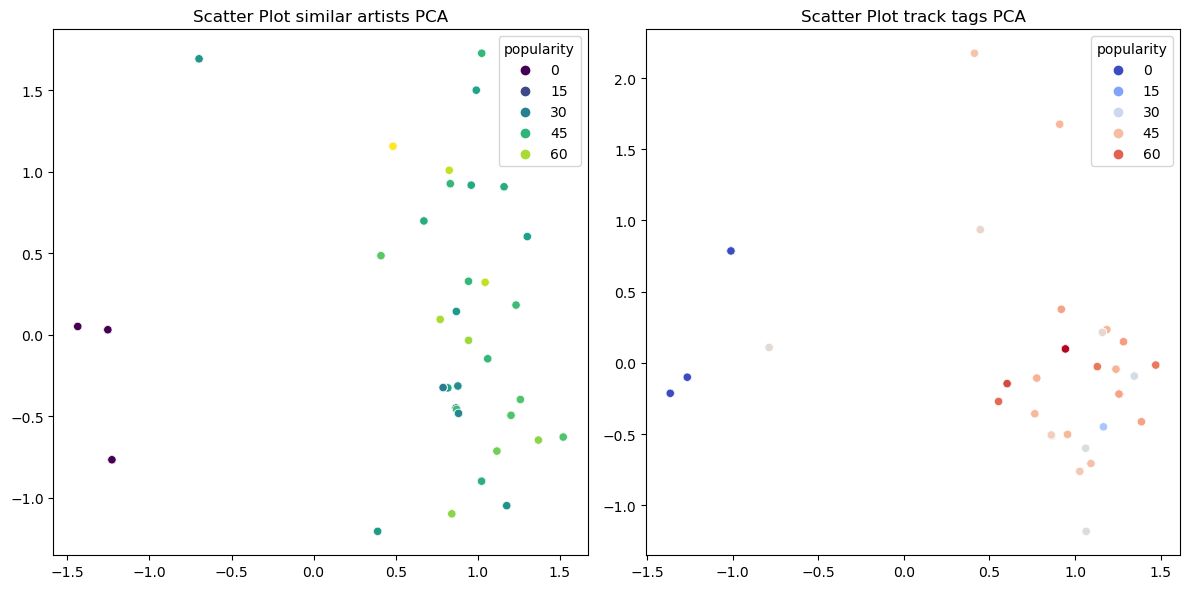

In [398]:
X = df_vect['similar_artists'].apply(pd.Series).fillna(0)
Y = df_vect['track_tags'].apply(pd.Series).fillna(0)

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)
Y_pca = pca.fit_transform(Y)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_vect['popularity'], palette="viridis")
plt.title("Scatter Plot similar artists PCA")

plt.subplot(1, 2, 2)
sns.scatterplot(x=Y_pca[:,0], y=Y_pca[:,1], hue=df_vect['popularity'], palette="coolwarm")
plt.title("Scatter Plot track tags PCA")

plt.tight_layout()
plt.show()

c:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

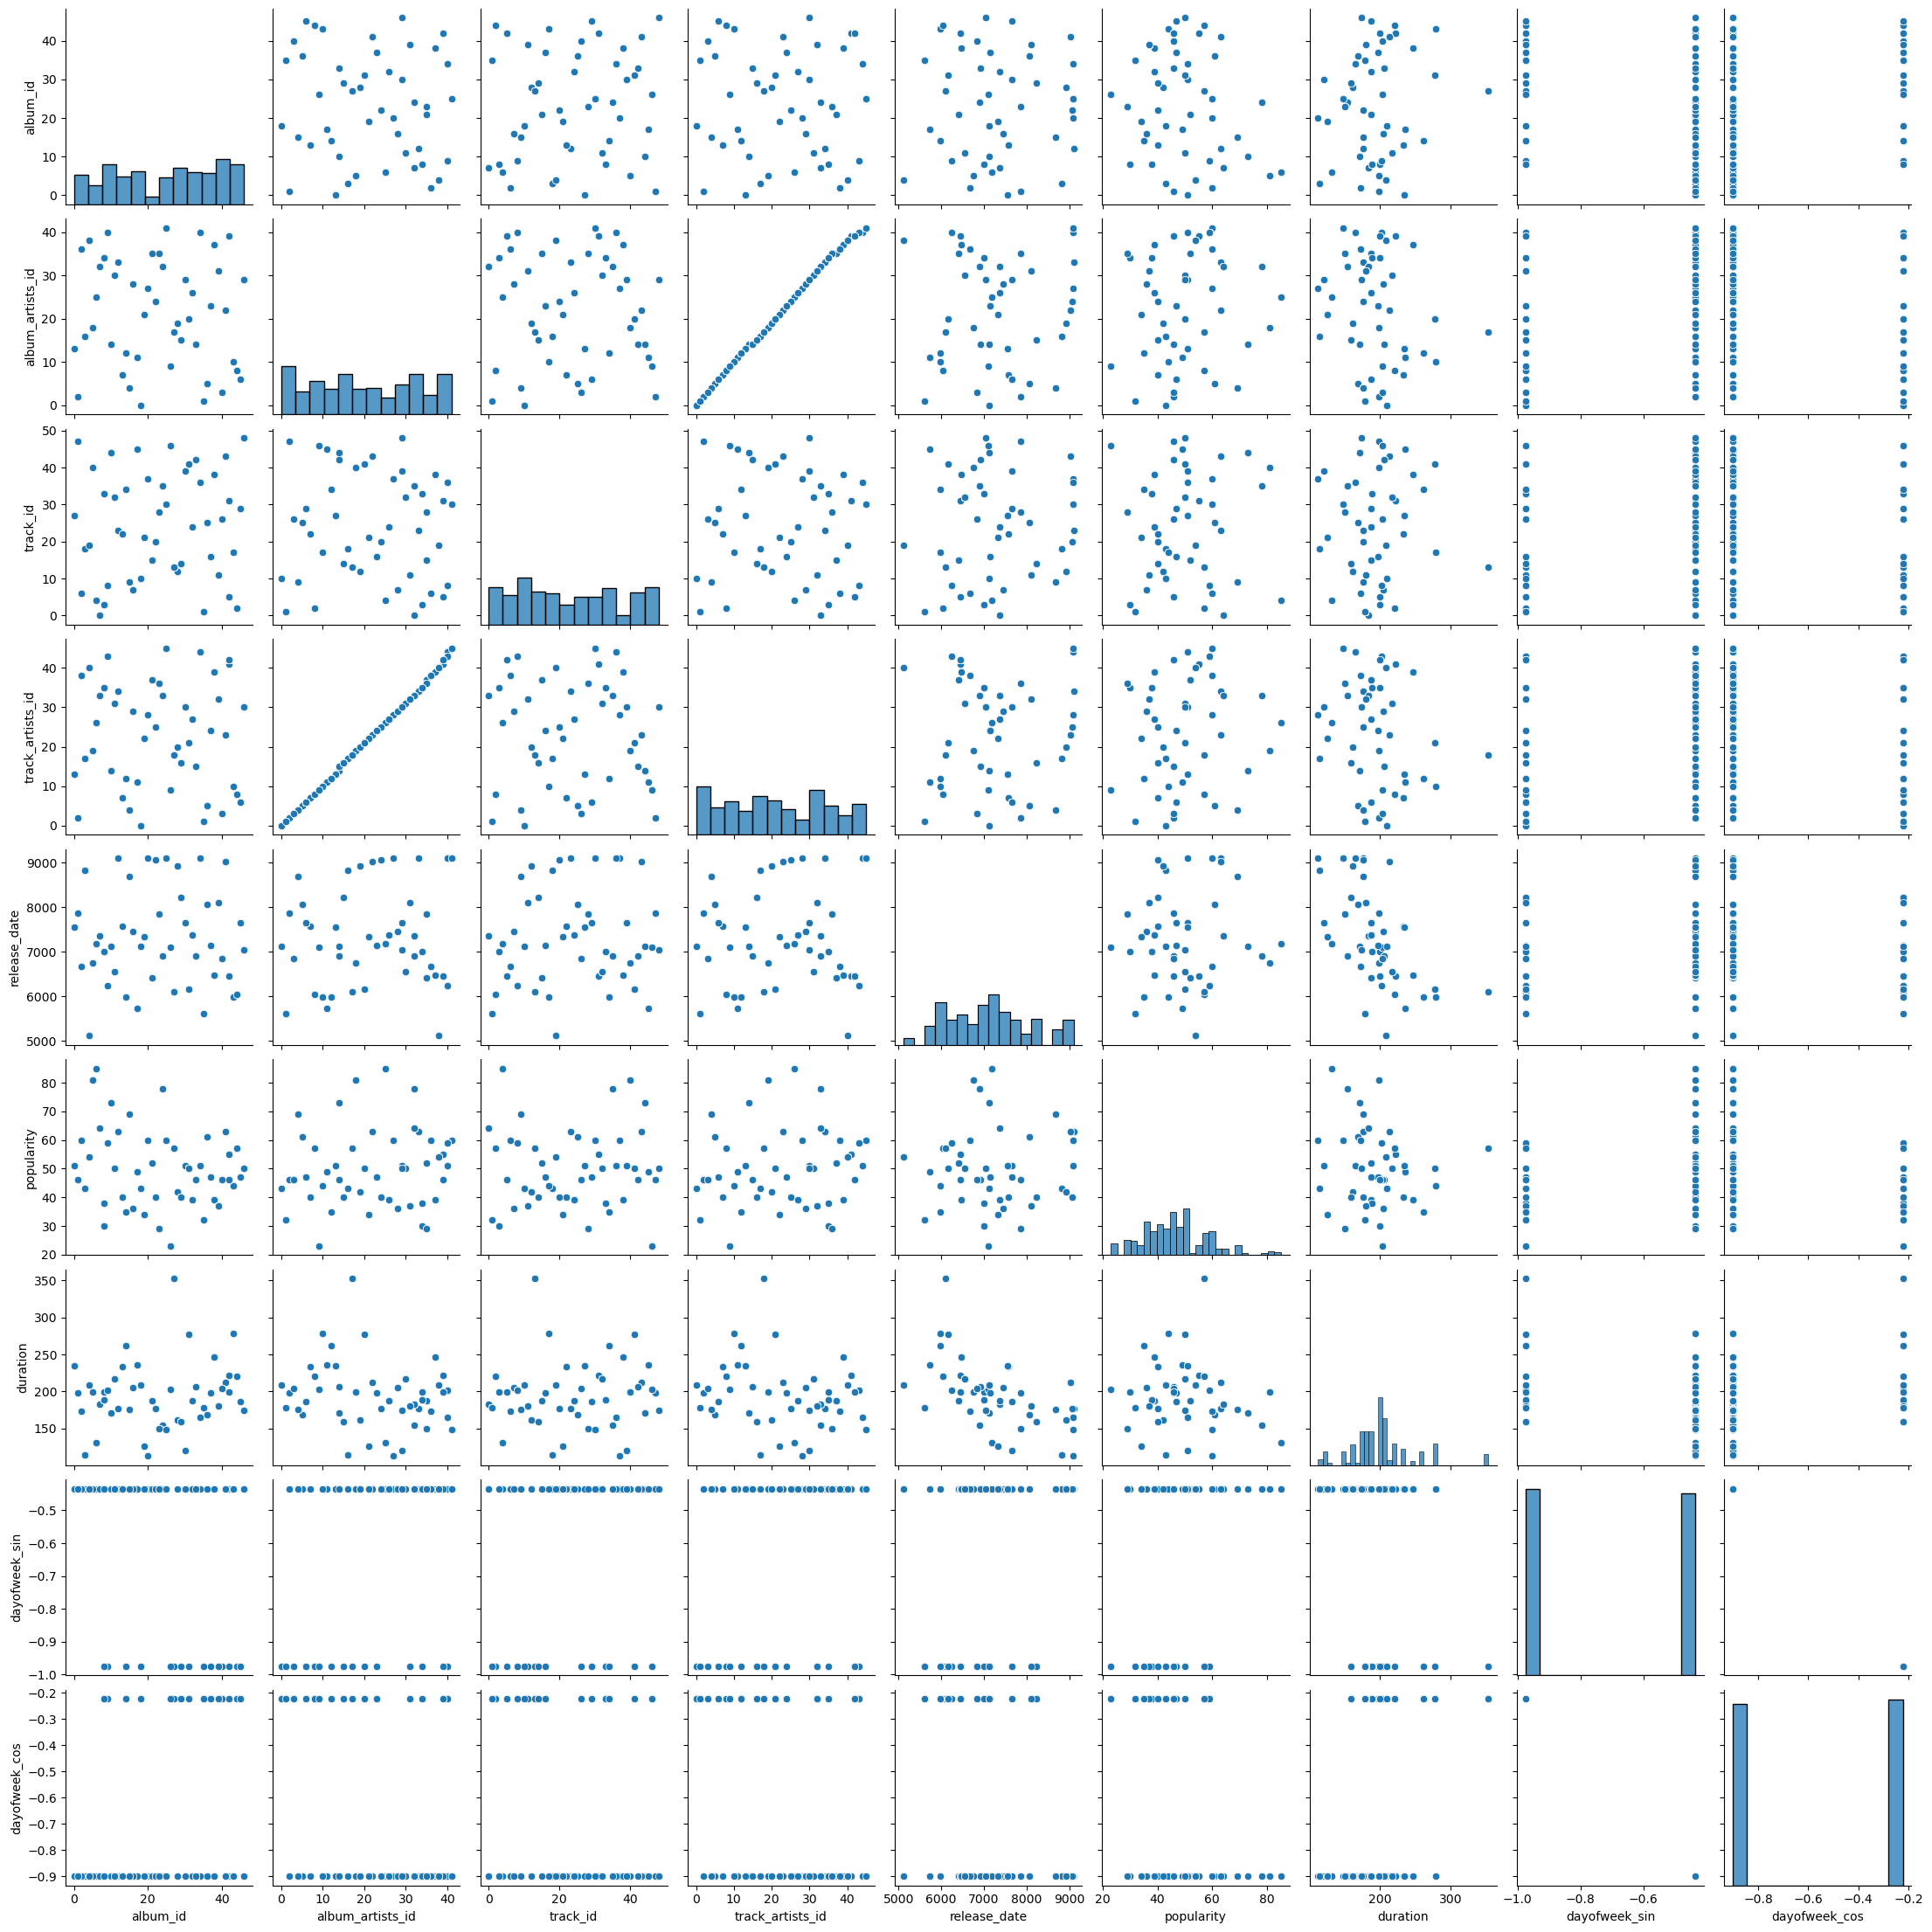

In [240]:
# Analyze relations between features
sns.pairplot(data=df_vect[['album_id', 'album_artists_id', 'track_id', 'track_artists_id', 'release_date', 'popularity', 'duration', 'dayofweek_sin', 'dayofweek_cos']], hue=None, diag_kind='hist')
plt.show()

c:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


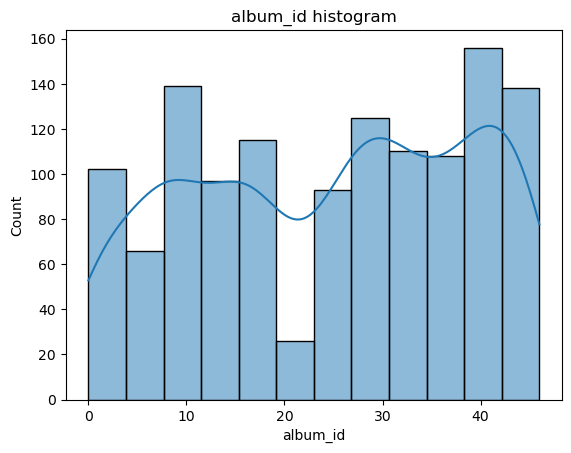

c:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


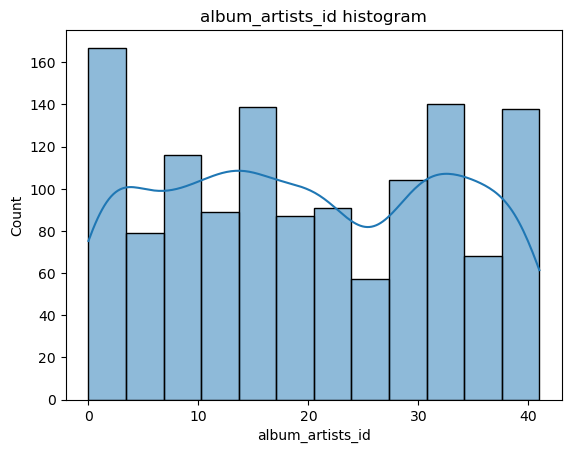

c:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


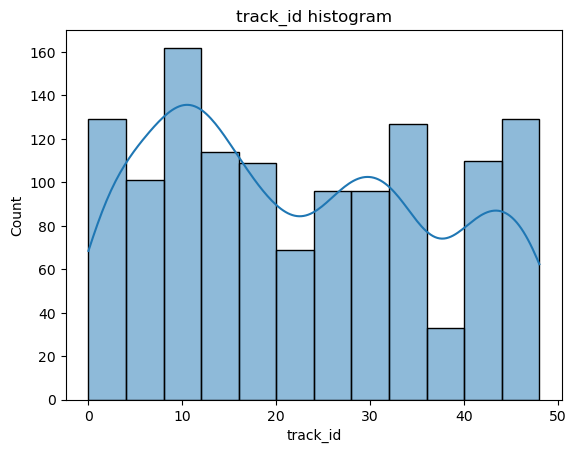

c:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


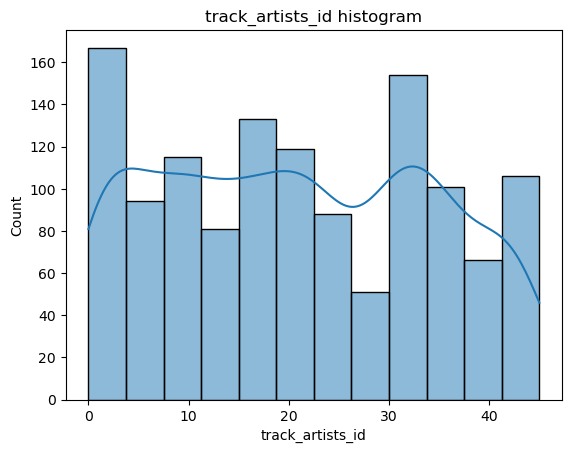

c:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


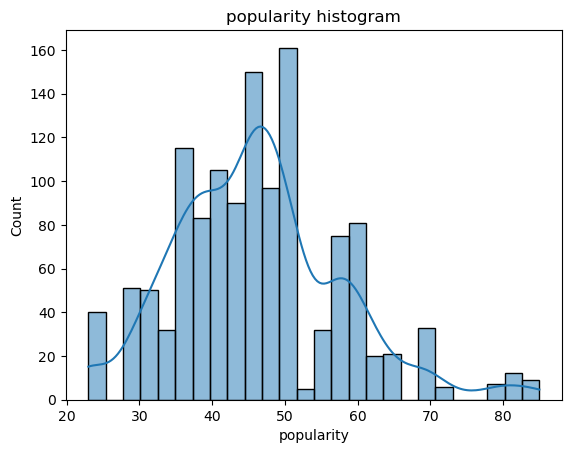

c:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


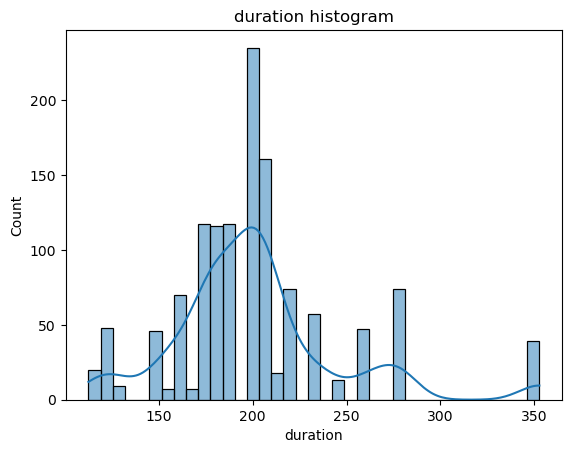

In [241]:
for col in ['album_id', 'album_artists_id', 'track_id', 'track_artists_id', 'popularity', 'duration']:
    sns.histplot(df_vect[col], kde=True)
    plt.title(f"{col} histogram")
    plt.show()

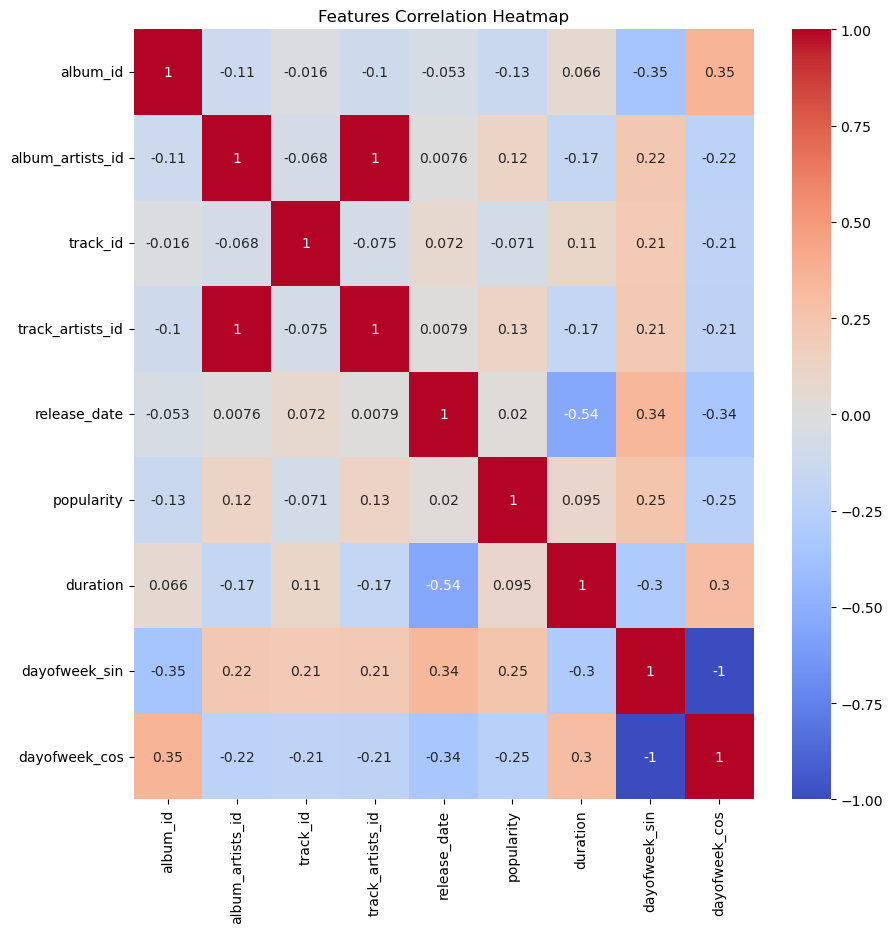

In [242]:
corr = df_vect[['album_id', 'album_artists_id', 'track_id', 'track_artists_id', 'release_date', 'popularity', 'duration', 'dayofweek_sin', 'dayofweek_cos']].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Features Correlation Heatmap")
plt.show()

In [ ]:
### Statistic tests

# Normality test : Shapiro-Wilk, Kolmogorov

### Develop ML Models

In [403]:
df_vect.columns

Index(['total_tracks', 'track_number', 'popularity', 'duration', 'album_id',
       'album_artists_id', 'track_id', 'track_artists_id', 'context_type',
       'release_date', 'year', 'month', 'day', 'dayofweek', 'hour',
       'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'day_sin',
       'day_cos', 'similar_artists', 'track_tags'],
      dtype='object')

c:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

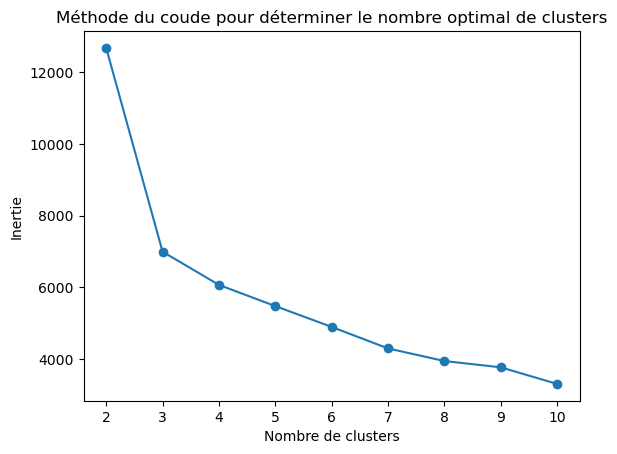

c:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


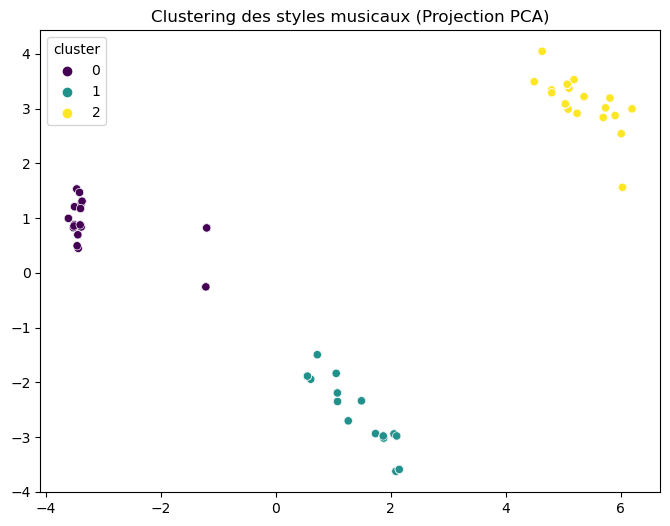

In [446]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### First of all : Clustering with K-Means

pca = PCA(n_components=1)

similar_artists_vect = pca.fit_transform(df_vect['similar_artists'].apply(pd.Series).fillna(0))
track_tags_vect = pca.fit_transform(df_vect['track_tags'].apply(pd.Series).fillna(0))

df_vect_test = df_vect.copy()
df_vect_test.drop(['similar_artists', 'track_tags'], axis=1, inplace=True)
df_vect_test = pd.concat([df_vect_test, pd.DataFrame(similar_artists_vect), pd.DataFrame(track_tags_vect)], axis=1)

df_vect_test.columns = df_vect_test.columns.astype(str)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_vect_test)

inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.title("Méthode du coude pour déterminer le nombre optimal de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_vect_test['cluster'] = kmeans.fit_predict(X_scaled)

pca_df = PCA(n_components=2)
X_pca = pca_df.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_vect_test['cluster'], palette="viridis")
plt.title("Clustering des styles musicaux (Projection PCA)")
plt.show()

In [447]:
df_vect_test['cluster'].value_counts()

cluster
0    459
1    370
2    171
Name: count, dtype: int64

In [452]:
df_vect['cluster'] = df_vect_test['cluster']
df['cluster'] = df_vect_test['cluster']

In [453]:
df.columns

Index(['album_id', 'album_name', 'release_date', 'total_tracks',
       'album_artists_id', 'album_artists_name', 'disc_number', 'duration',
       'track_id', 'track_name', 'popularity', 'track_number',
       'track_artists_id', 'track_artists_name', 'similar_artists',
       'track_tags', 'track_listeners', 'track_playcount', 'played_at',
       'context_type', 'cluster'],
      dtype='object')

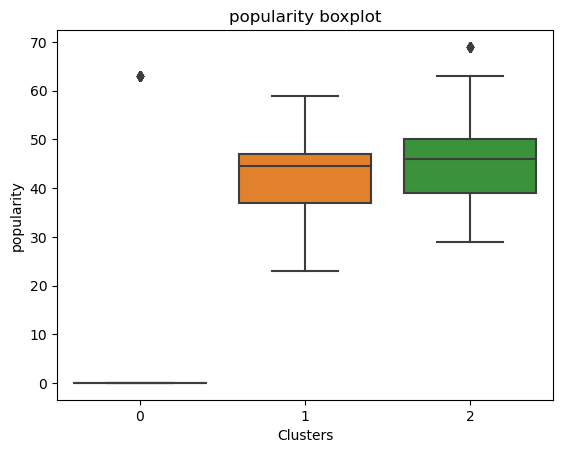

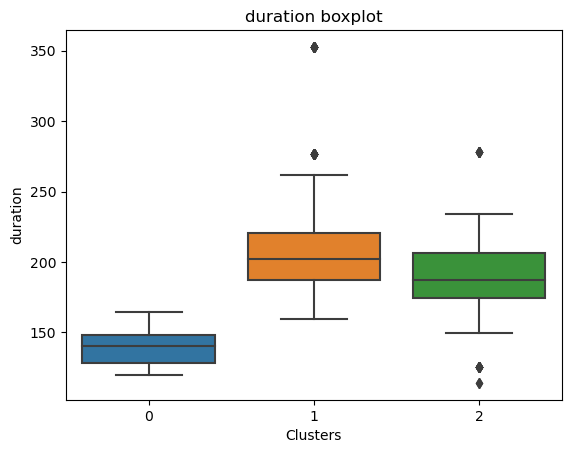

In [ ]:
for col in ['popularity', 'duration']:  ### Uniquement pour colonnes de type numérique
    sns.boxplot(data=df, x='cluster', y=col)
    plt.title(f"{col} boxplot")
    plt.xlabel('Clusters')
    plt.ylabel(col)
    plt.show()

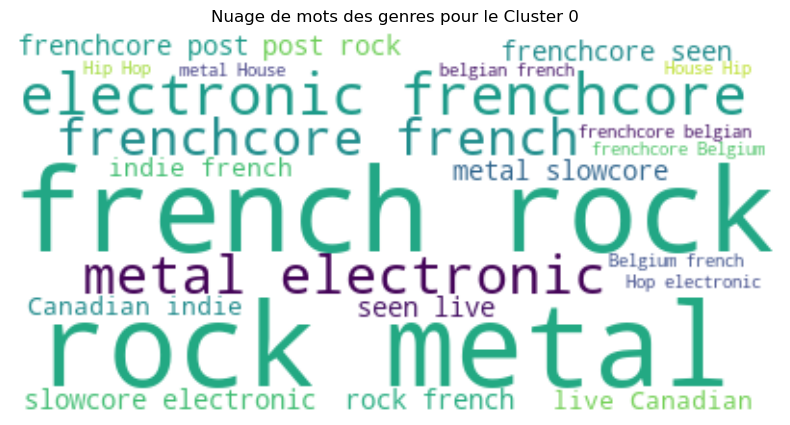

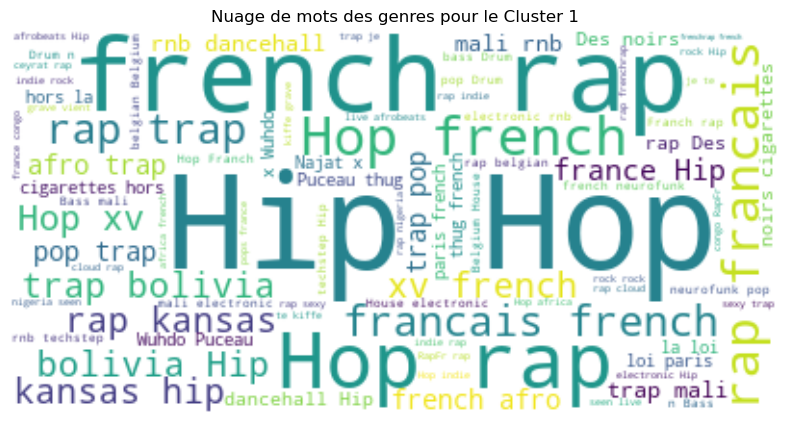

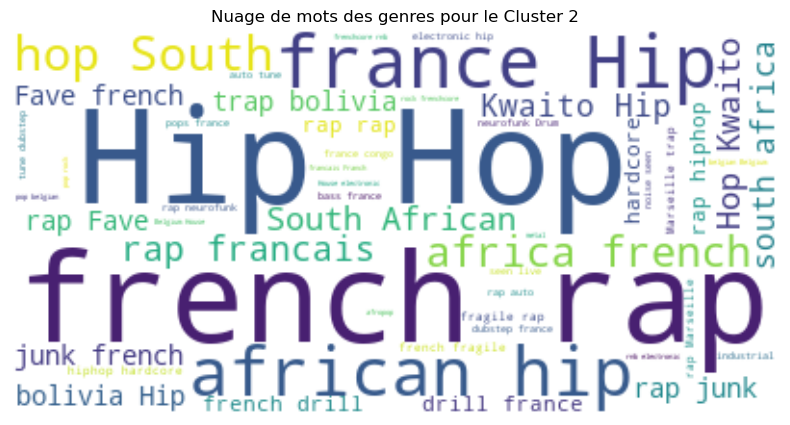

In [459]:
from wordcloud import WordCloud

for cluster in df["cluster"].unique():
    text = " ".join(df[df["cluster"] == cluster]["track_tags"].dropna())
    
    wordcloud = WordCloud(width=400, height=200, background_color="white").generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nuage de mots des genres pour le Cluster {cluster}")
    plt.show()

c:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


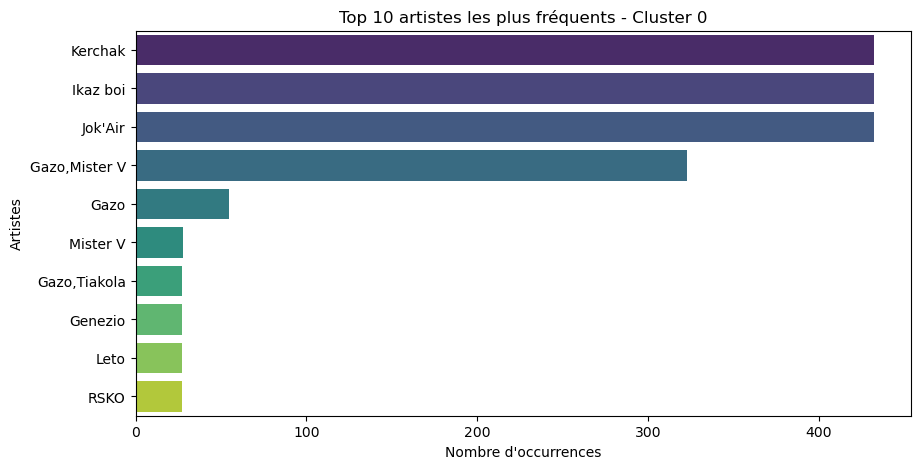

c:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


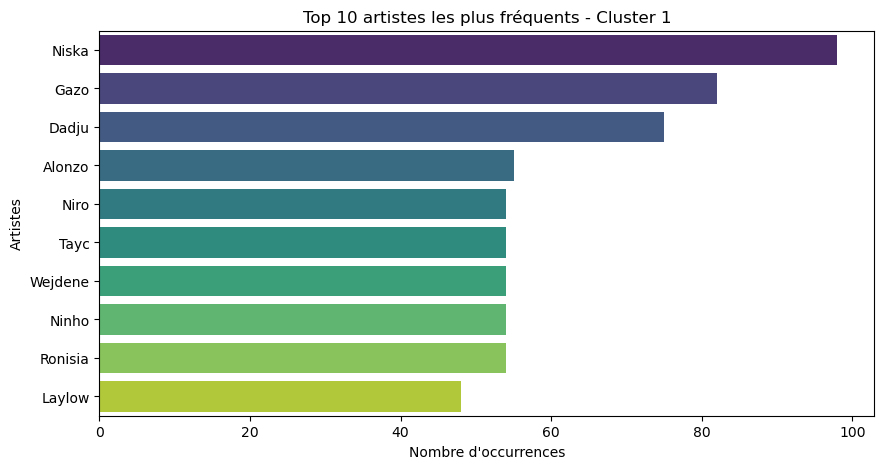

c:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


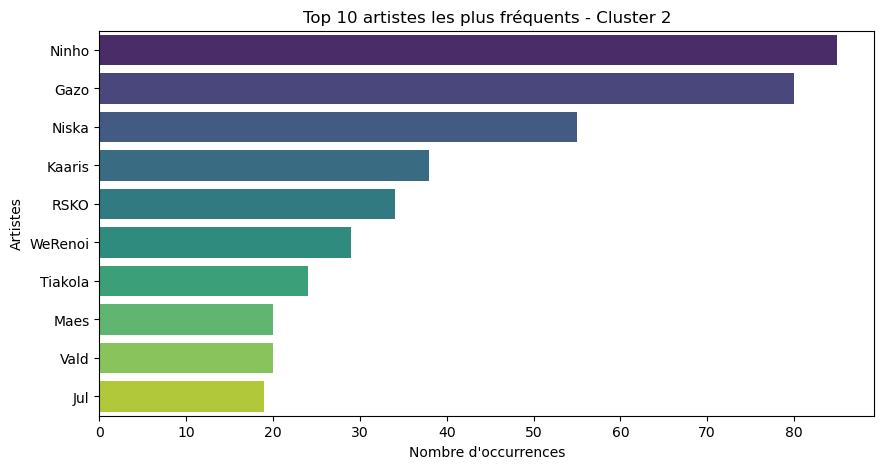

In [460]:
from collections import Counter

for cluster in df["cluster"].unique():
    all_artists = ",".join(df[df["cluster"] == cluster]["similar_artists"].dropna()).split(", ")
    
    artist_counts = Counter(all_artists)
    most_common_artists = artist_counts.most_common(10)

    if len(most_common_artists) == 0:
        print(f"Aucun artiste trouvé pour le cluster {cluster}")
        continue
    
    artists, counts = zip(*most_common_artists)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(artists), palette="viridis")
    plt.title(f"Top 10 artistes les plus fréquents - Cluster {cluster}")
    plt.xlabel("Nombre d'occurrences")
    plt.ylabel("Artistes")
    plt.show()

c:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


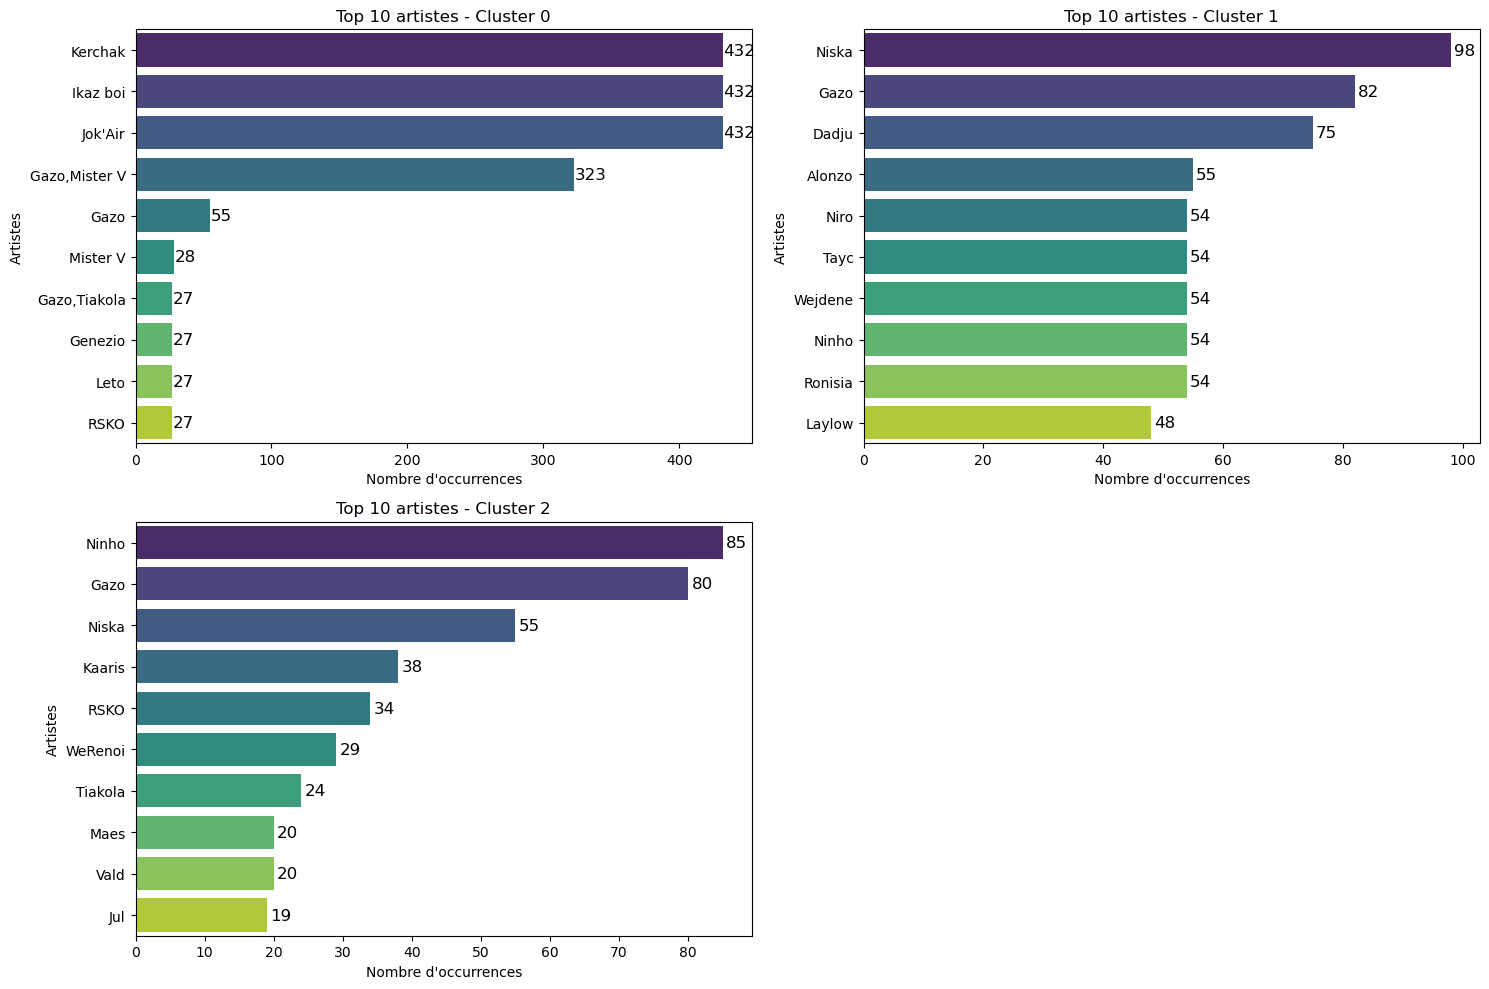

In [462]:
clusters = df["cluster"].unique()
num_clusters = len(clusters)

# Créer une figure avec un layout 2x2 (2 graphiques en haut, 1 centré en bas)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2 lignes, 2 colonnes

# Liste des positions disponibles (axes)
positions = [(0, 0), (0, 1), (1, 0)]  # Deux en haut, un centré en bas

for i, cluster in enumerate(clusters):
    if i >= len(positions):  # Si plus de clusters que prévu
        break
    
    row, col = positions[i]  # Position dans la grille
    
    all_artists = ",".join(df[df["cluster"] == cluster]["track_artists_id"].dropna()).split(", ")
    artist_counts = Counter(all_artists)
    most_common_artists = artist_counts.most_common(10)

    if len(most_common_artists) == 0:
        print(f"Aucun artiste trouvé pour le cluster {cluster}")
        continue
    
    artists, counts = zip(*most_common_artists)

    ax = axes[row, col]  # Sélectionner l'axe correspondant
    sns.barplot(x=list(counts), y=list(artists), palette="viridis", ax=ax)  # Graphique sur l'axe spécifique
    
    ax.set_title(f"Top 10 artistes - Cluster {cluster}")
    ax.set_xlabel("Nombre d'occurrences")
    ax.set_ylabel("Artistes")

    # Ajouter les labels au bout de chaque barre
    for index, value in enumerate(counts):
        ax.text(value + 0.5, index, str(value), va='center', fontsize=12)  # Positionner le texte légèrement à droite

# Supprimer le dernier subplot inutilisé
fig.delaxes(axes[1, 1])

# Ajuster l'espace entre les graphiques
plt.tight_layout()
plt.show()

In [67]:
test = spotify.get_recent_tracks(10)
test_vect = spotify.vectorize_recent_tracks(test)
clusters=spotify.clustering(test_vect)
test['cluster'] = clusters
test

,album_id,album_name,release_date,album_artists_id,album_artists_name,duration,track_id,track_name,popularity,track_artists_id,track_artists_name,similar_artists,track_tags,track_listeners,track_playcount,played_at,context_type,cluster
0,58BulCOhy9evaH2rSsMBku,Icône,2019-06-21,2bbQRkTmEgKA1INGHeH7oT,Cheu-B,202.986,7B5DE7G5gp3IZGprz1aIxX,Client,23,2bbQRkTmEgKA1INGHeH7oT,Cheu-B,"Diddi Trix, 13 Block, Siboy, stavo, Ateyaba","rap, je te kiffe grave vient a ceyrat, rap fra...",1013,7742,2025-02-10 19:29:15.260000+00:00,playlist,1
1,2C9n8eixRjvea1KNEPr3ek,TieksVie,2018-03-16,2UwqpfQtNuhBwviIC0f2ie,Damso,168.000,0IbEikMmfMHeR4oEcMUO8O,TieksVie,49,2UwqpfQtNuhBwviIC0f2ie,Damso,"Nekfeu, Dinos, Vald, Hamza, Josman","rap, Hip-Hop, Belgium, trap, hip hop",12959,117824,2025-02-10 19:25:51.767000+00:00,playlist,1
2,2GZtCmVHspYEXhGmpRPO4S,D.U.C.,2015-04-13,58wXmynHaAWI5hwlPZP3qL,Booba,190.360,1uFKIIkJGN04w6WaLiU0Nu,G-Love,52,"58wXmynHaAWI5hwlPZP3qL, 329e4yvIujISKGKz1BZZbO","Booba, Farruko","Wisin, J Alvarez, Andy Rivera, Kaaris, SCH, La...","Puerto Rican, rap, rap francais, Hip-Hop, farr...",5513,36797,2025-02-10 19:23:03.210000+00:00,playlist,1
3,6sc32xJv1eJErLgB8xVMeu,Instinct Animal Réédition,2015-05-18,0bLmm8afVAt8Vb5nhPsx1B,XV,178.317,0GpkYYhoXVC9Z1xG0egE34,Black Dance,31,0bLmm8afVAt8Vb5nhPsx1B,XV,"Vic Mensa, Joe Budden, Lloyd Banks, Curren$y, ...","rap, Hip-Hop, xv, kansas, hip hop",1527,11698,2025-02-10 19:19:52.400000+00:00,playlist,1
4,20T2S3PLZZ7EMMh8AuBCO0,Paradise,2019-03-01,5gs4Sm2WQUkcGeikMcVHbh,Hamza,219.436,23C92tGAEx3hJhs5IVq84F,Audemars Shit,36,5gs4Sm2WQUkcGeikMcVHbh,Hamza,"Damso, Jok'Air, Green Montana, Josman, Laylow","House, Belgium, Hip-Hop, belgian, electronic",8275,75686,2025-02-10 19:16:53.615000+00:00,playlist,1
5,6d1vGZsr6Uy3h9IigBpPAf,Meet The Woo,2019-07-26,0eDvMgVFoNV3TpwtrVCoTj,Pop Smoke,214.960,0fIffclhgJC5h8AdMMVvkp,Welcome To The Party,64,0eDvMgVFoNV3TpwtrVCoTj,Pop Smoke,"Rah Swish, Fivio Foreign, DUSTY LOCANE, Lil Tj...","rap, Hip-Hop, trap, drill, hip hop",261936,2758122,2025-02-10 19:13:13.714000+00:00,playlist,0
6,6d1vGZsr6Uy3h9IigBpPAf,Meet The Woo,2019-07-26,0eDvMgVFoNV3TpwtrVCoTj,Pop Smoke,214.960,0fIffclhgJC5h8AdMMVvkp,Welcome To The Party,64,0eDvMgVFoNV3TpwtrVCoTj,Pop Smoke,"Rah Swish, Fivio Foreign, DUSTY LOCANE, Lil Tj...","rap, Hip-Hop, trap, drill, hip hop",261936,2758122,2025-02-10 19:09:39.169000+00:00,playlist,0
7,7hv9Xs3hmzGbxLPhH7Nog5,Anarchie,2016-05-20,2kXKa3aAFngGz2P4GjG5w2,SCH,278.306,3DuSMlQqRx6RviEnSH64Oa,Himalaya,44,2kXKa3aAFngGz2P4GjG5w2,SCH,"KEKRA, Kaaris, Booba, Dinos, Green Montana","rap, noise, industrial, seen live, french rap",5908,67354,2025-02-10 18:20:08.199000+00:00,playlist,1
8,5GFHFEASZeJF0gyWuDDjGE,Dans la légende,2016-09-16,3NH8t45zOTqzlZgBvZRjvB,PNL,268.346,2lFWyfuXtCN8Sb7cHJILva,J'suis QLF,51,3NH8t45zOTqzlZgBvZRjvB,PNL,"KEKRA, Freeze Corleone, Damso, Green Montana, ...","rap, Hip-Hop, hip hop, cloud rap, french",24183,349121,2025-02-10 18:15:29.352000+00:00,playlist,1
9,6B1WrwSNvznff0JjxjjPxd,Survie,2020-12-18,54kCbQZaZWHnwwj9VP2hn4,Zola,120.746,5yg5qjncnCYEgC3QtQSrea,Sanchez,51,54kCbQZaZWHnwwj9VP2hn4,Zola,"Jul, Kaaris, Ninho, Booba, Damso","South African Hip Hop, south africa, Hip-Hop, ...",9332,91410,2025-02-10 18:11:00.501000+00:00,playlist,1


In [68]:
test.columns

Index(['album_id', 'album_name', 'release_date', 'album_artists_id',
       'album_artists_name', 'duration', 'track_id', 'track_name',
       'popularity', 'track_artists_id', 'track_artists_name',
       'similar_artists', 'track_tags', 'track_listeners', 'track_playcount',
       'played_at', 'context_type', 'cluster'],
      dtype='object')

In [7]:
### Fonction qui donne toutes les musiques similaires aux musiques du cluster 
### Utiliser get_track_details avec la méthode 'track.getSimilar' (ex: get_track_details('Astroboy', 'Zola', api_key_lastfm, 'track.getSimilar'))

n_clusters = test['cluster'].nunique()  ## nombre de clusters (.value_count() pour savoir cb d'occurences dans chaque)

### 1st step : ajouter une colonne au dataframe avec tous les tracks similaires au track correspondant à la ligne
similar_tracks_list = []

for i in range(len(test)):

    similar_tracks = spotify.get_track_details(
        track=test['track_name'].iloc[i],
        artist=test['track_artists_name'].iloc[i].split(",")[0], 
        api_key=api_key_lastfm, 
        method='track.getSimilar'
    )

    current_similar_tracks_list = []

    if "error" in similar_tracks:
        current_similar_tracks_list.append(None)
    else:
        similar_tracks = similar_tracks.get('similartracks', {}).get('track', {})
        current_similar_tracks_list.extend([track['name'] for track in similar_tracks])

    similar_tracks_str = ", ".join([track for track in set(current_similar_tracks_list) if track is not None])

    similar_tracks_list.append(similar_tracks_str)

test['similar_tracks'] = similar_tracks_list

### Step 2 : Faire une liste de tracks similaires par cluster + tracks du cluster

#test_vect['cluster'] = clusters
clusters_tracklist = []
for i in range(n_clusters):
    cluster = test[test['cluster']==i]

    tracklist = test['similar_tracks'].str.split(', ').explode().dropna()
    tracklist = pd.concat([tracklist, test['track_name'].str.split(', ').explode().dropna()])
    tracklist = tracklist[tracklist != ''].unique().tolist()

    clusters_tracklist.append(tracklist)

### Step 3 : On vectorize la colonne "similar_tracks" en utilisant les listes que l'on vient de créer (méthode pca ou pas forcément besoin avec utilisation de cosine similarty ensuite))

### On merge le nom du track avec les nom des tracks similaires avant de vectorizer
test['total_tracks'] = test.apply(
    lambda row: ', '.join(set([row['track_name']] + row['similar_tracks'].split(', '))) 
    if pd.notna(row['similar_tracks']) else row['track_name'], axis=1
)

test_vect['tracks_vect'] = None 

for i in range(n_clusters):
    total_tracks = test.loc[test['cluster']==i, 'total_tracks']
    tracks_vectorized = total_tracks.str.split(', ').apply(lambda x: pd.Series(clusters_tracklist[i]).isin(x).astype(int).tolist())
    test_vect.loc[test['cluster'] == i, 'tracks_vect'] = tracks_vectorized

pca = PCA(n_components=10)     ### Tester avec différentes valeurs de n_components

tracks_pca = pd.DataFrame(pca.fit_transform(test_vect['tracks_vect'].apply(pd.Series).fillna(0)))

test_vect = pd.concat([test_vect, tracks_pca], axis=1)

### Step 4 : cosine similarity entre le dernier track et tous les tracks similaires du cluster (!! il ne faut pas que ce soit le même track --> enlever cette possibilité)


### Ajouter des infos sur les tracks pour plus de fiabilité avec cosine similarity (ne fonctionne pas juste avec track_id)

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_matrix = cosine_similarity(test_vect[['total_tracks', 'track_number', 'popularity', 'duration',         
                    'album_id', 'album_artists_id', 'track_id', 'track_artists_id', 'context_type',
                    'release_date', 'year', 'month', 'day', 'dayofweek', 'hour', 'month_sin', 'month_cos', 'dayofweek_sin',
                    'dayofweek_cos', 'day_sin', 'day_cos', 'track_tags', 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]])

In [10]:
similarities = list(enumerate(cosine_sim_matrix[-1]))  # on cherche pour le dernier track
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)  # Trier par similarité décroissante

# Récupérer les indices des 5 tracks les plus proches (en excluant le track lui-même)
top_similar_tracks = [test.iloc[i[0]]['track_name'] for i in similarities[1:6]]
top_similar_tracks = list(dict.fromkeys(top_similar_tracks))
top_similar_tracks_str = ", ".join(top_similar_tracks)
print("Tracks similaires à", test.iloc[-1]['track_name'], ":", top_similar_tracks_str)

Tracks similaires à Sanchez : Welcome To The Party, Client, Audemars Shit, TieksVie


In [80]:
cluster_dfs = {}

for i in range(n_clusters):
    cluster = test[test['cluster']==i]
    cluster = cluster[['album_id', 'album_name', 'release_date', 'album_artists_id', 'album_artists_name', 'duration',
            'track_id', 'track_name', 'popularity', 'track_artists_id', 'track_artists_name',
            'track_listeners', 'track_playcount', 'similar_artists', 'track_tags']]
    l=len(cluster)

    for j in range(l):
        similar_tracks = spotify.get_track_details(
            track=cluster['track_name'].iloc[j],
            artist=cluster['track_artists_name'].iloc[j].split(",")[0], 
            api_key=api_key_lastfm, 
            method='track.getSimilar'
        )
        
        if "error" not in similar_tracks:
            similar_tracks = similar_tracks.get('similartracks', {}).get('track', {})[:7]  ### Limite pour temps respectable
            for track in similar_tracks:
                new_track = pd.json_normalize(spotify.search_track(track['name'], track['artist']['name']))
                new_track_details = spotify.get_track_details(
                    track=track['name'], 
                    artist=track['artist']['name'], 
                    api_key=api_key_lastfm, 
                    method='track.getInfo'
                )

                if "error" in new_track_details:
                    new_track_details_df = pd.DataFrame(columns=['track_listeners', 'track_playcount'])
                else:
                    new_track_details_df = pd.json_normalize(new_track_details.get('track', {})).get(['listeners', 'playcount'], pd.DataFrame())
                    new_track_details_df.rename(columns={'listeners': 'track_listeners', 'playcount': 'track_playcount'}, inplace=True)
                
                similar_artists_list = []
                track_tags_list = []

                artist_details = spotify.get_artist_details(artist=track['artist']['name'], api_key=api_key_lastfm, method='artist.getInfo')

                if "error" in artist_details:
                    similar_artists_list.append(None)
                else:
                    similar_artists = artist_details.get('artist', {}).get('similar', {}).get('artist', [])
                    similar_artists_list.extend([similar_artist['name'] for similar_artist in similar_artists])

                if "error" in artist_details:
                    track_tags_list.append(None)
                else:
                    tags = artist_details.get('artist', {}).get('tags', {}).get('tag', [])
                    track_tags_list.extend([tag['name'] for tag in tags])
                        
                similar_artists_str = ", ".join([artist for artist in set(similar_artists_list) if artist is not None])     # Use of set in order to avoid duplicates
                track_tags_str = ", ".join([track for track in set(track_tags_list) if track is not None])      # Use of set in order to avoid duplicates

                new_track_details_df['similar_artists'] = similar_artists_str
                new_track_details_df['track_tags'] = track_tags_str

                new_track = pd.concat([new_track, new_track_details_df], axis=1)

                if not new_track.empty:
                    cluster = pd.concat([cluster, new_track], axis=0)
        
    cluster.drop_duplicates(subset=['track_name'], inplace=True)
    cluster['release_date'] = pd.to_datetime(cluster['release_date'], errors='coerce')
    cluster.reset_index(drop=True, inplace=True)
        
    cluster_dfs[i] = cluster if not cluster.empty else pd.DataFrame()

In [98]:
cluster_dfs = spotify.get_tracklist(test)
cluster_dfs

{0:                  album_id    album_name release_date        album_artists_id  \
 0  6d1vGZsr6Uy3h9IigBpPAf  Meet The Woo   2019-07-26  0eDvMgVFoNV3TpwtrVCoTj   
 
   album_artists_name  duration                track_id            track_name  \
 0          Pop Smoke    214.96  0fIffclhgJC5h8AdMMVvkp  Welcome To The Party   
 
    popularity        track_artists_id track_artists_name track_listeners  \
 0          64  0eDvMgVFoNV3TpwtrVCoTj          Pop Smoke          261936   
 
   track_playcount                                    similar_artists  \
 0         2758122  Rah Swish, Fivio Foreign, DUSTY LOCANE, Lil Tj...   
 
                            track_tags  
 0  rap, Hip-Hop, trap, drill, hip hop  ,
 1:                   album_id                                         album_name  \
 0   58BulCOhy9evaH2rSsMBku                                              Icône   
 1   2C9n8eixRjvea1KNEPr3ek                                           TieksVie   
 2   2GZtCmVHspYEXhGmpRPO4S      

In [99]:
cluster_test = cluster_dfs[1]
cluster_test.columns

Index(['album_id', 'album_name', 'release_date', 'album_artists_id',
       'album_artists_name', 'duration', 'track_id', 'track_name',
       'popularity', 'track_artists_id', 'track_artists_name',
       'track_listeners', 'track_playcount', 'similar_artists', 'track_tags'],
      dtype='object')

In [100]:
cluster_test

,album_id,album_name,release_date,album_artists_id,album_artists_name,duration,track_id,track_name,popularity,track_artists_id,track_artists_name,track_listeners,track_playcount,similar_artists,track_tags
0,58BulCOhy9evaH2rSsMBku,Icône,2019-06-21,2bbQRkTmEgKA1INGHeH7oT,Cheu-B,202.986,7B5DE7G5gp3IZGprz1aIxX,Client,23,2bbQRkTmEgKA1INGHeH7oT,Cheu-B,1013,7742,"Diddi Trix, 13 Block, Siboy, stavo, Ateyaba","rap, je te kiffe grave vient a ceyrat, rap fra..."
1,2C9n8eixRjvea1KNEPr3ek,TieksVie,2018-03-16,2UwqpfQtNuhBwviIC0f2ie,Damso,168.000,0IbEikMmfMHeR4oEcMUO8O,TieksVie,49,2UwqpfQtNuhBwviIC0f2ie,Damso,12959,117824,"Nekfeu, Dinos, Vald, Hamza, Josman","rap, Hip-Hop, Belgium, trap, hip hop"
2,2GZtCmVHspYEXhGmpRPO4S,D.U.C.,2015-04-13,58wXmynHaAWI5hwlPZP3qL,Booba,190.360,1uFKIIkJGN04w6WaLiU0Nu,G-Love,52,"58wXmynHaAWI5hwlPZP3qL, 329e4yvIujISKGKz1BZZbO","Booba, Farruko",5513,36797,"Wisin, J Alvarez, Andy Rivera, Kaaris, SCH, La...","Puerto Rican, rap, rap francais, Hip-Hop, farr..."
3,6sc32xJv1eJErLgB8xVMeu,Instinct Animal Réédition,2015-05-18,0bLmm8afVAt8Vb5nhPsx1B,XV,178.317,0GpkYYhoXVC9Z1xG0egE34,Black Dance,31,0bLmm8afVAt8Vb5nhPsx1B,XV,1527,11698,"Vic Mensa, Joe Budden, Lloyd Banks, Curren$y, ...","rap, Hip-Hop, xv, kansas, hip hop"
4,20T2S3PLZZ7EMMh8AuBCO0,Paradise,2019-03-01,5gs4Sm2WQUkcGeikMcVHbh,Hamza,219.436,23C92tGAEx3hJhs5IVq84F,Audemars Shit,36,5gs4Sm2WQUkcGeikMcVHbh,Hamza,8275,75686,"Damso, Jok'Air, Green Montana, Josman, Laylow","House, Belgium, Hip-Hop, belgian, electronic"
5,7hv9Xs3hmzGbxLPhH7Nog5,Anarchie,2016-05-20,2kXKa3aAFngGz2P4GjG5w2,SCH,278.306,3DuSMlQqRx6RviEnSH64Oa,Himalaya,44,2kXKa3aAFngGz2P4GjG5w2,SCH,5908,67354,"KEKRA, Kaaris, Booba, Dinos, Green Montana","rap, noise, industrial, seen live, french rap"
6,5GFHFEASZeJF0gyWuDDjGE,Dans la légende,2016-09-16,3NH8t45zOTqzlZgBvZRjvB,PNL,268.346,2lFWyfuXtCN8Sb7cHJILva,J'suis QLF,51,3NH8t45zOTqzlZgBvZRjvB,PNL,24183,349121,"KEKRA, Freeze Corleone, Damso, Green Montana, ...","rap, Hip-Hop, hip hop, cloud rap, french"
7,6B1WrwSNvznff0JjxjjPxd,Survie,2020-12-18,54kCbQZaZWHnwwj9VP2hn4,Zola,120.746,5yg5qjncnCYEgC3QtQSrea,Sanchez,51,54kCbQZaZWHnwwj9VP2hn4,Zola,9332,91410,"Jul, Kaaris, Ninho, Booba, Damso","South African Hip Hop, south africa, Hip-Hop, ..."
8,1opEoEslu38jE4CGTnoV12,Fais-moi un Vie,2018-03-16,2UwqpfQtNuhBwviIC0f2ie,Damso,167.080,4TTLq43WaxxkYZE9mq9kPY,Fais-moi un Vie,45,2UwqpfQtNuhBwviIC0f2ie,Damso,10468,105284,"Nekfeu, Dinos, Vald, Hamza, Josman","rap, Hip-Hop, Belgium, trap, hip hop"
9,3uTtvVojWHPJlzuMfVOyc2,CQFD,2018-03-16,2UwqpfQtNuhBwviIC0f2ie,Damso,118.533,7KJDIC7u13vHV3FSNlVD2Z,CQFD,44,2UwqpfQtNuhBwviIC0f2ie,Damso,9915,91757,"Nekfeu, Dinos, Vald, Hamza, Josman","rap, Hip-Hop, Belgium, trap, hip hop"


In [101]:
from sklearn.preprocessing import MultiLabelBinarizer
### Vectoriser les df de chaque cluster
cluster_test = cluster_dfs[1]

encoder = LabelEncoder()
cluster_vect = cluster_test[['popularity', 'duration', 'track_listeners', 'track_playcount']].copy()

### Encode all the ids
cluster_vect['album_id'] = encoder.fit_transform(cluster_test['album_id'])
cluster_vect['track_id'] = encoder.fit_transform(cluster_test['track_id'])

cluster_test['track_artists_id'] = cluster_test['track_artists_id'].fillna('').apply(lambda x: x.split(', '))
cluster_test['album_artists_id'] = cluster_test['album_artists_id'].fillna('').apply(lambda x: x.split(', '))

mlb = MultiLabelBinarizer()
encoded_artists = pd.DataFrame(mlb.fit_transform(cluster_test['track_artists_id']))
encoded_albums = pd.DataFrame(mlb.fit_transform(cluster_test['album_artists_id']))

cluster_vect = pd.concat([cluster_vect, encoded_artists, encoded_albums], axis=1)

reference_date = datetime.strptime('01-01-2000', '%d-%m-%Y')
cluster_vect['release_date'] = (cluster_test['release_date'] - reference_date).dt.days

# Vectorize similar_artists and track_tags
unique_artists = cluster_test['similar_artists'].str.split(', ').explode().dropna()
unique_artists = unique_artists[unique_artists != ''].unique().tolist()

unique_tags = cluster_test['track_tags'].str.split(', ').explode().dropna()
unique_tags = unique_tags[unique_tags != ''].unique().tolist()

def vectorize_column(column, unique_values):
    return column.str.split(', ').apply(lambda x: pd.Series(unique_values).isin(x).astype(int).tolist())
    
similar_artists_vect = vectorize_column(cluster_test['similar_artists'], unique_artists)
track_tags_vect = vectorize_column(cluster_test['track_tags'], unique_tags)

### On convertit les vecteurs en float
pca = PCA(n_components=1)

cluster_vect['similar_artists'] = pd.DataFrame(pca.fit_transform(similar_artists_vect.apply(pd.Series).fillna(0)))
cluster_vect['track_tags'] = pd.DataFrame(pca.fit_transform(track_tags_vect.apply(pd.Series).fillna(0)))

cluster_vect['track_artists_id'] = pd.DataFrame(pca.fit_transform(encoded_artists.fillna(0)))
cluster_vect['album_artists_id'] = pd.DataFrame(pca.fit_transform(encoded_albums.fillna(0)))

print(cluster_vect)

    popularity  duration track_listeners track_playcount  album_id  track_id  \
0           23   202.986            1013            7742        10        20   
1           49   168.000           12959          117824         2         1   
2           52   190.360            5513           36797         3         4   
3           31   178.317            1527           11698        13         0   
4           36   219.436            8275           75686         1         6   
5           44   278.306            5908           67354        16        11   
6           51   268.346           24183          349121        11         9   
7           51   120.746            9332           91410        12        17   
8           45   167.080           10468          105284         0        13   
9           44   118.533            9915           91757         7        21   
10          53   270.840           20088          239719        15        10   
11          62   205.893           20856

In [103]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_matrix = cosine_similarity(cluster_vect)

In [108]:
l_clust = len(test[test['cluster']==1])

similarities = list(enumerate(cosine_sim_matrix[0]))  # on cherche pour le dernier track
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)  # Trier par similarité décroissante

# Récupérer les indices des 5 tracks les plus proches (en excluant le track lui-même)
top_similar_tracks = [cluster_dfs[1].iloc[i[0]]['track_name'] for i in similarities[1:6]]
top_similar_tracks = list(dict.fromkeys(top_similar_tracks))
top_similar_tracks_str = ", ".join(top_similar_tracks)
print("Tracks similaires à", test[test['cluster']==1].iloc[0]['track_name'], ":", top_similar_tracks_str)

Tracks similaires à Client : Black Dance, Murcielago, Quand on était momes, G-Love, Adelanto - Extrait de la BO de « En Passant Pécho »


In [ ]:
### Limites de cette recommandation : 
### Ici, cela ne permet uniquement de recommander des tracks qui ont déjà été écoutés précédemment. 

### Idée : à l'aide des tracks similaires trouvés pour chaque cluster, construire un nouveau dataframe pour chaque track similaire 
### et on viendra ensuite prendre la cosine similarity du track que l'on souhaite avec les autres tracks de ce tableau. 

In [ ]:
### Step 1 : Créer un df des tracks + tracks similaires par cluster --> puis matrice cosine similarity

### Step 2 : intégrer les patterns d'écoute (fréquence + récence d'écoute) --> ajuster coefs de matrice cosine similarity


### Autres idées : - Word2Vec pour capter les relations entre séquences d'écoute

### - LightFM : modèle hybride (content-based + collaborative filtering)

### - Deep Learning pour capturer les patterns d'écoute (LSTM)

### Modèle V1 : cosine similarity
### Modèle V2 : Word2Vec + LightFM + LSTM